<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture09/notebooks/L09_CNN_Transfer_pytorch_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferencia de Aprendizaje en el Conjunto de Datos Caltech101

En este cuaderno, consideraremos un conjunto de datos más complejo que MNIST o CIFAR10. Las imágenes en Caltech101 son imágenes RGB (3 canales) con tamaño variable. Hay 101 clases diferentes. Intentaremos una práctica muy común en visión por computadora en la actualidad: transferencia de aprendizaje desde un modelo preentrenado en ImageNet.

## Plan de Trabajo:
- Modificar la red del ejercicio anterior (CIFAR-10) para trabajar con imágenes de 224x224.
- Entrenar el modelo por un tiempo en Caltech101 y ver qué tan lejos podemos llegar.
- Tomar un ResNet34 que fue preentrenado en ImageNet-1k y ajustarlo a Caltech101.
  - Considerar tanto entrenar solo la cabeza (el clasificador lineal al final de la red) como toda la red.
  - Deberíamos poder alcanzar un mejor rendimiento que nuestra red original en menos pasos de entrenamiento.
- Opcional: experimentar con otros modelos preentrenados de `timm` (ver información [aquí](https://github.com/rwightman/pytorch-image-models)).

In [1]:
!pip install datasets


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


## Preliminares

In [2]:
%matplotlib inline
from typing import List, Optional, Callable, Iterator
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torchvision.models as models

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset
from datasets import load_dataset
from collections import Counter

sns.set_style("whitegrid")

def show_image(img, title=None):
    img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

## Configuración de la base de datos

In [3]:
# --- ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
default_imagenet_normalization = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)

# --- Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.25, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    default_imagenet_normalization,
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    default_imagenet_normalization,
])

# Step 1: Load dataset
hf_dataset = load_dataset("flwrlabs/caltech101", split="train")  # all in one split

# Step 2: Count class occurrences
label_counts = Counter(hf_dataset['label'])

# Step 3: Keep only classes with ≤100 samples
keep_classes = sorted([label for label, count in label_counts.items() if count <= 100])

# Step 4: Subsample max 100 samples per class
indices = list(range(len(hf_dataset)))
random.shuffle(indices)

new_indices = []
class_counts = {i: 0 for i in keep_classes}

for i in indices:
    y = hf_dataset[i]['label']
    if y in keep_classes and class_counts[y] < 100:
        new_indices.append(i)
        class_counts[y] += 1

# Step 5: Translate labels
def translate_label(y, keep_classes):
    try:
        return keep_classes.index(y)
    except ValueError:
        return -1

labels = [translate_label(hf_dataset[i]['label'], keep_classes) for i in new_indices]
assert max(labels) == len(keep_classes) - 1

labels = np.array(labels)
# Step 6: Train-test split
test_size = 640
val_size = 640
train_size = len(new_indices) - test_size - val_size

# First, split into train+val and test
train_val_idx, test_idx = train_test_split(
    new_indices,
    test_size=test_size,
    stratify=labels,
    random_state=42
)

# Map from full dataset index to position in new_indices
idx_map = {idx: i for i, idx in enumerate(new_indices)}

# Get label indices for train_val
train_val_labels = np.array([labels[idx_map[i]] for i in train_val_idx])

# Then, split train+val into train and val
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=val_size,
    stratify=train_val_labels,
    random_state=42
)

# --- Torch Dataset wrapper
class HFCaltech101(Dataset):
    def __init__(self, hf_dataset, indices, transform, keep_classes):
        self.hf_dataset = hf_dataset
        self.indices = indices
        self.transform = transform
        self.keep_classes = keep_classes

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        item = self.hf_dataset[self.indices[idx]]
        image = item['image'].convert('RGB')
        label = translate_label(item['label'], self.keep_classes)

        if self.transform:
            image = self.transform(image)
        return image, label

# --- Datasets and loaders
train_dataset = HFCaltech101(hf_dataset, train_idx, train_transform, keep_classes)
val_dataset = HFCaltech101(hf_dataset, val_idx, test_transform, keep_classes)
test_dataset = HFCaltech101(hf_dataset, test_idx, test_transform, keep_classes)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Un Vistazo Más Cercano al Conjunto de Datos

Primero, trazamos el tamaño de cada clase y observamos que la distribución de clases no es uniforme.

Luego, mostramos ejemplos aleatorios del conjunto de datos, anotados con la etiqueta de la clase y el índice.
Ten en cuenta que las imágenes de entrenamiento incluyen aumentos estándar que se utilizan típicamente en modelos de visión (definidos anteriormente).


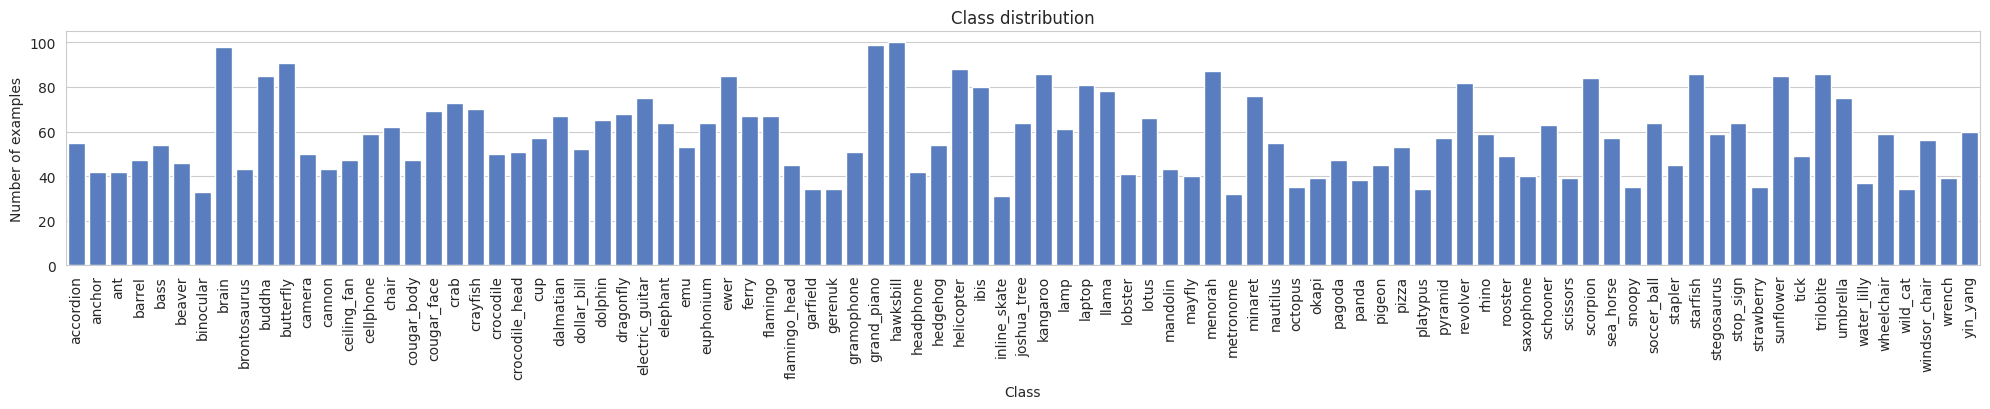



Train images (including augmentations):


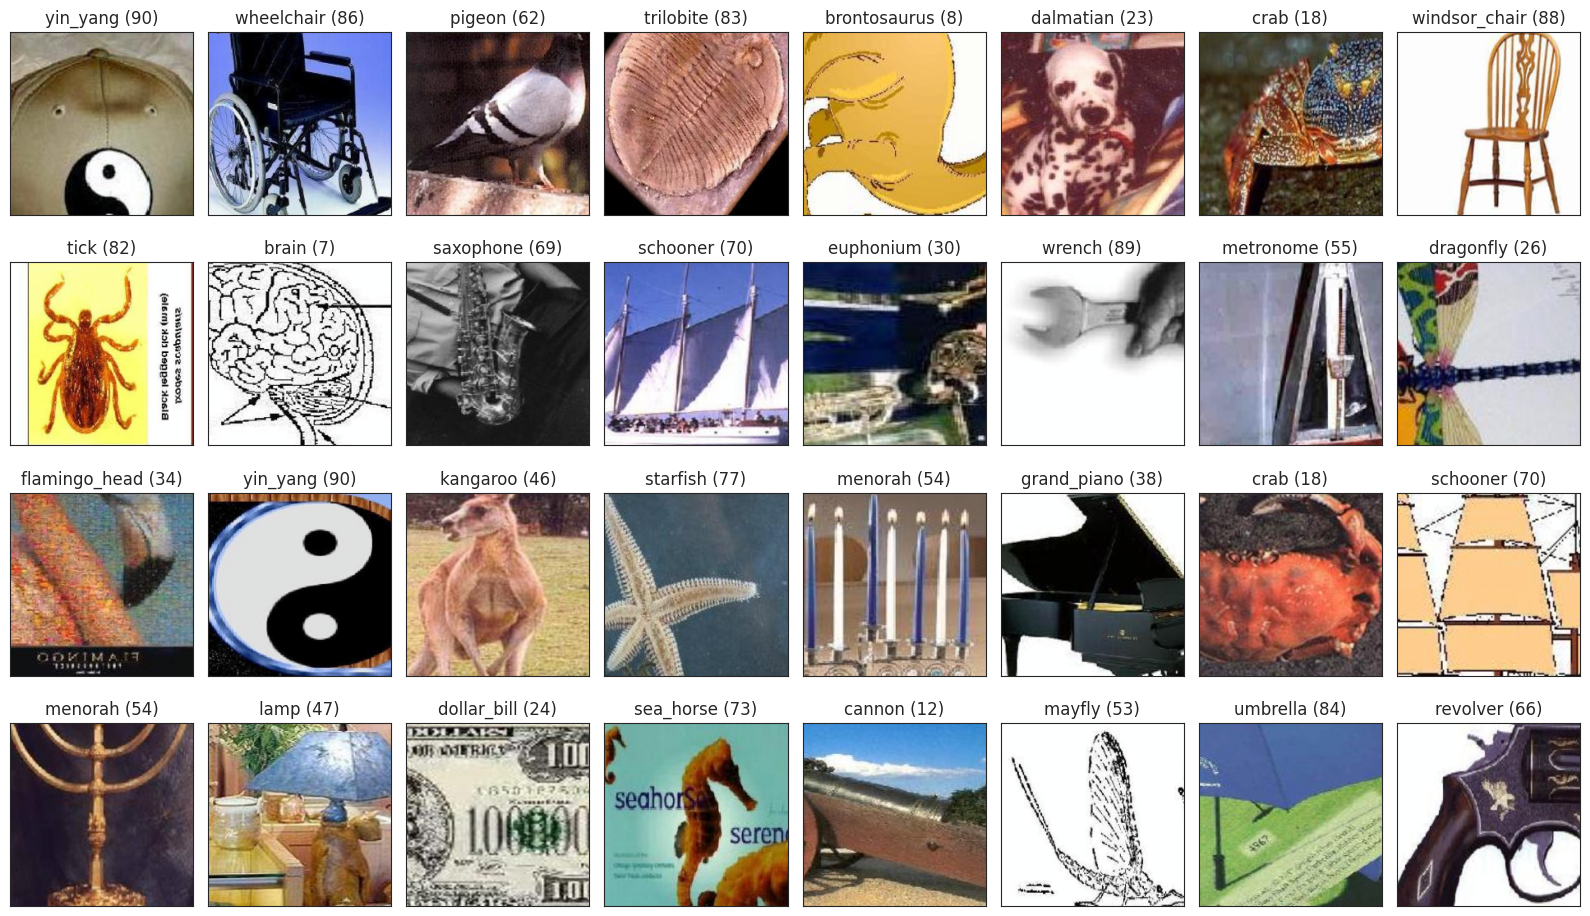



Train images (including augmentations):


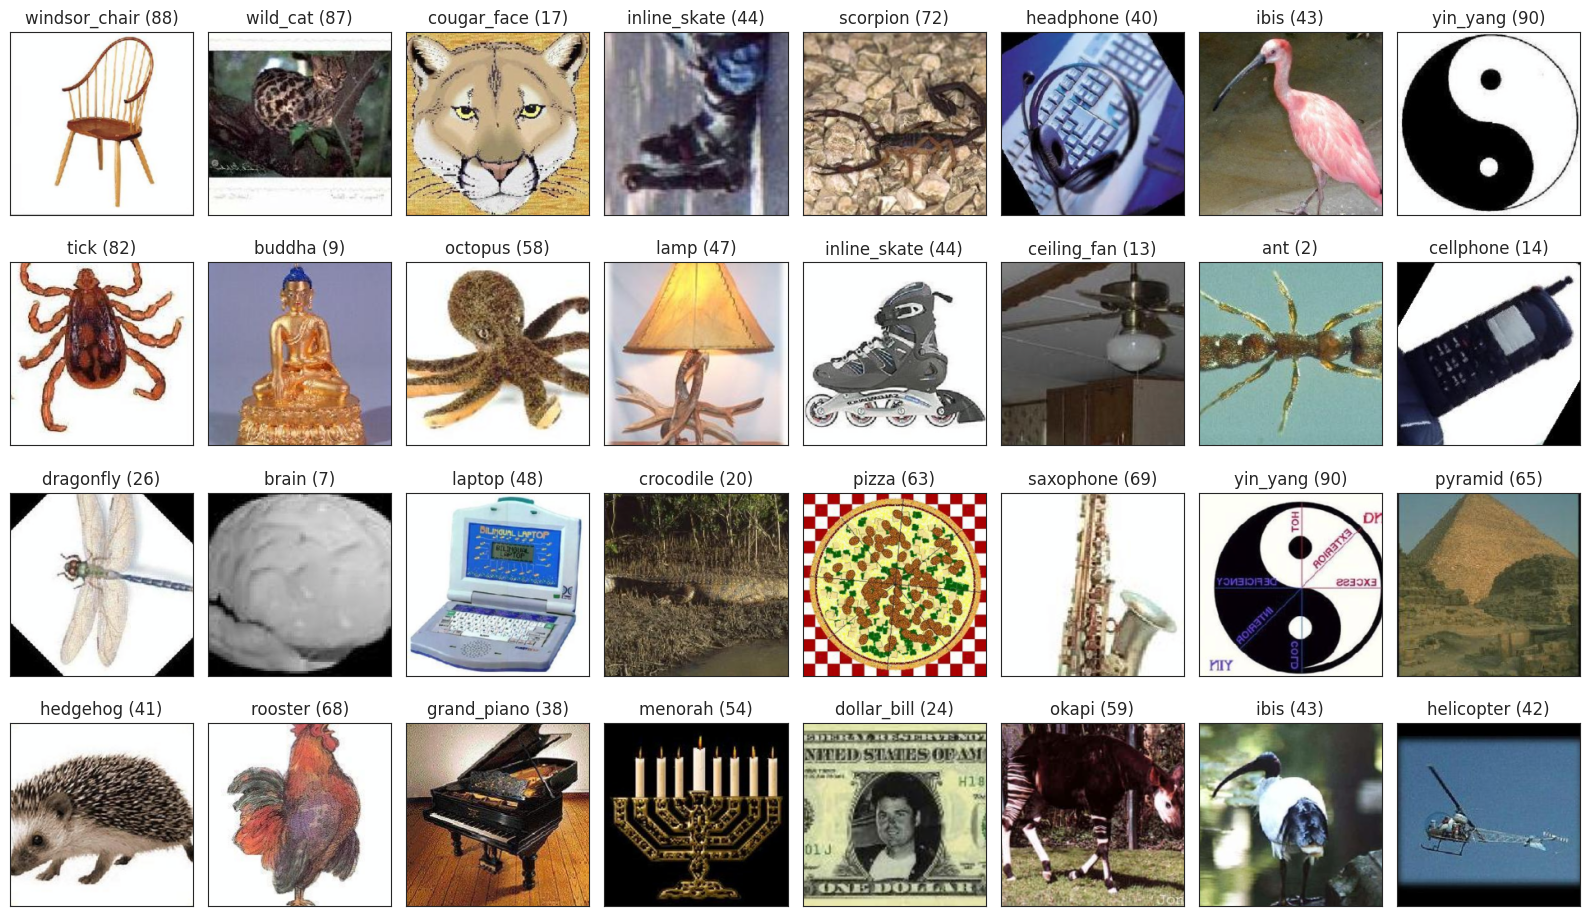



Test images:


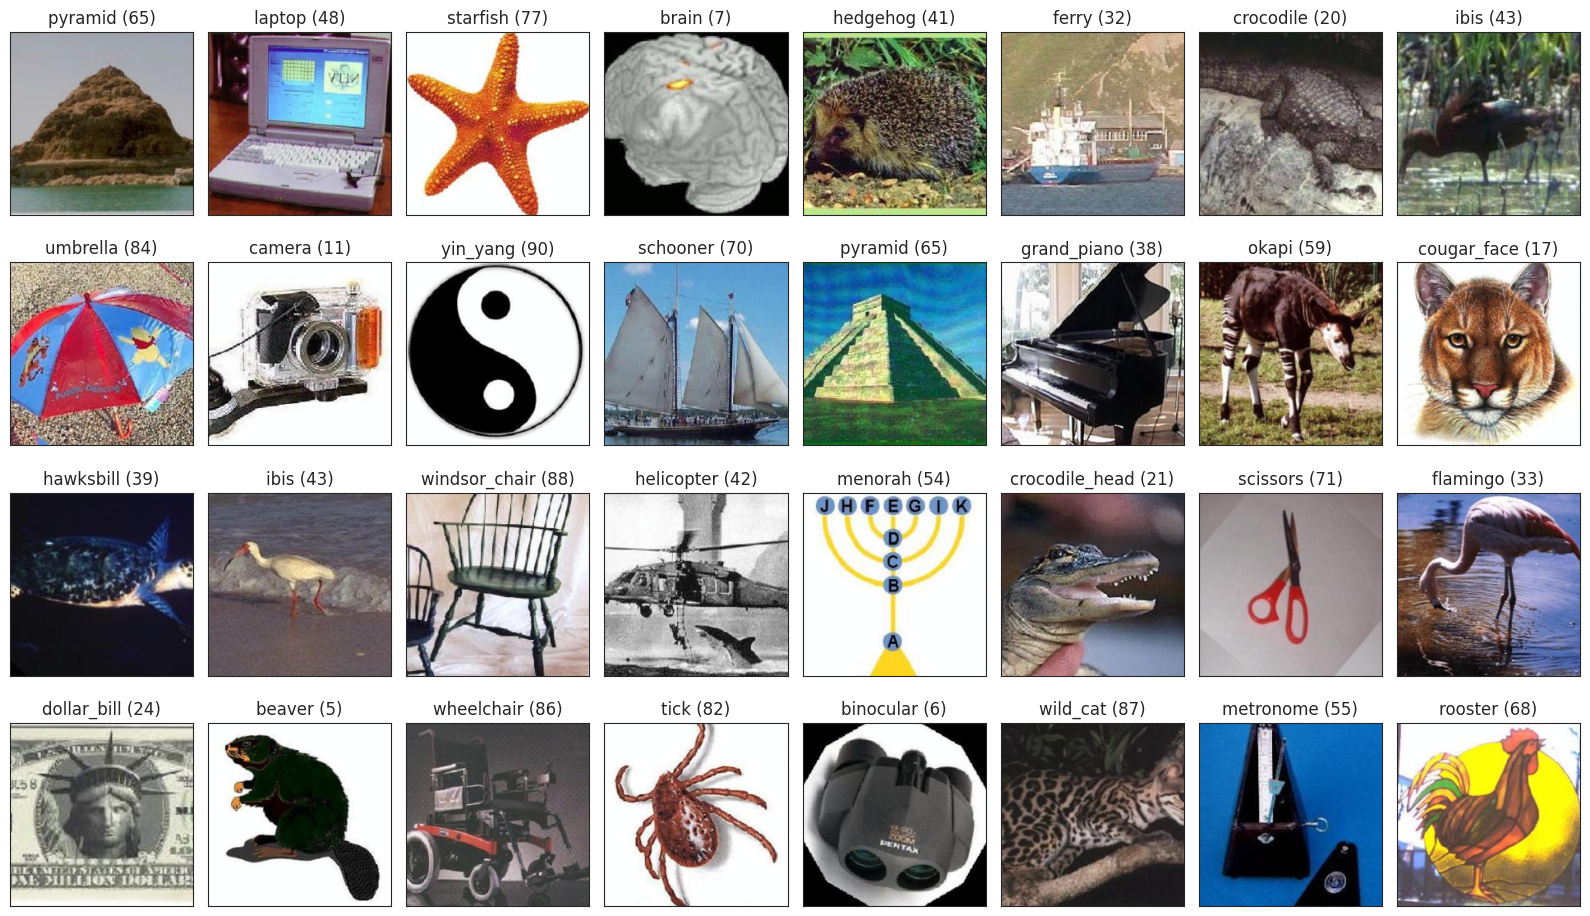

In [4]:
full_label_names = hf_dataset.features['label'].names
categories = [full_label_names[i] for i in keep_classes]

label_idxs, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(20, 4.2))
sns.barplot(
    x=[categories[label] for label in label_idxs],
    y=counts,
    color=sns.color_palette('muted')[0]
)
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.title("Class distribution")
plt.tight_layout()
plt.show()


def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))
    with sns.axes_style("white"):
        fig, axes = plt.subplots(4, 8, figsize=(16, 9.5))
    axes = [ax for axes_ in axes for ax in axes_]   # flatten

    for j, (img, label) in enumerate(zip(images[:32], labels[:32])):
        plt.sca(axes[j])
        show_image(img, title=f"{categories[label.item()]} ({label.item()})")

    plt.tight_layout()
    plt.show()


print("\n\nTrain images (including augmentations):")
show_dataset_examples(train_loader)
print("\n\nTrain images (including augmentations):")
show_dataset_examples(val_loader)
print("\n\nTest images:")
show_dataset_examples(test_loader)

## Definir una Red Neuronal

**Asignación 1:** Adapta la CNN del laboratorio anterior (CIFAR-10) para manejar imágenes de 224x224. Recomendamos reducir significativamente el tamaño de los tensores antes de aplanarlos, añadiendo capas convolucionales con `stride > 1` o capas de [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) (pero también puedes considerar [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)).


In [ ]:
class Model(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)


model = Model(num_classes=len(np.unique(labels)))
device = torch.device('cuda')  # use cuda or cpu
model = model.to(device)
print(model)

Model(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=50176, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=91, bias=True)
  )
)


## Definir la Función de Pérdida y el Optimizador

**Asignación 2:** Implementa el criterio y el optimizador, como en el cuaderno anterior.

In [16]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(model.parameters(), lr = 0.001)  # Your code here!

## Entrenar la red

In [17]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 224, 224).to(device))
print("Output shape:", out.size())

Output shape: torch.Size([2, 91])


In [18]:
def accuracy(targets, predictions):
    return (predictions == targets).float().mean().item()

num_epochs = 10
validation_every_steps = 50

step = 0
model.train()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_accuracies_batches = []
    train_loss_accum = 0
    train_loss_steps = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # --- Forward pass
        output = model(inputs)

        # --- Loss
        loss = loss_fn(output, targets)
        train_losses.append(loss.item())
        train_loss_accum += loss.item()
        train_loss_steps += 1

        # --- Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Accuracy
        predictions = output.argmax(dim=1)
        train_accuracies_batches.append(accuracy(targets, predictions))

        step += 1

        # --- Validation
        if step % validation_every_steps == 0:
            avg_train_loss = train_loss_accum / train_loss_steps
            avg_train_acc = np.mean(train_accuracies_batches)
            train_accuracies.append(avg_train_acc)

            train_loss_accum = 0
            train_loss_steps = 0
            train_accuracies_batches = []

            model.eval()
            val_accuracies_batches = []
            val_loss_accum = 0
            num_val_samples = 0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)

                    val_loss = loss_fn(output, targets)
                    val_loss_accum += val_loss.item() * len(inputs)
                    num_val_samples += len(inputs)

                    predictions = output.argmax(dim=1)
                    val_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

            val_accuracy = np.sum(val_accuracies_batches) / num_val_samples
            avg_val_loss = val_loss_accum / num_val_samples
            val_accuracies.append(val_accuracy)
            val_losses.append(avg_val_loss)

            print(f"Step {step:<5}   "
                  f"train loss: {avg_train_loss:.4f}   train acc: {avg_train_acc:.4f}   "
                  f"val loss: {avg_val_loss:.4f}   val acc: {val_accuracy:.4f}")

            model.train()

print("Finished training.")

Step 50      train loss: 4.4663   train acc: 0.0244   val loss: 4.3504   val acc: 0.0422
Step 100     train loss: 4.2143   train acc: 0.0671   val loss: 4.1440   val acc: 0.0813
Step 150     train loss: 4.0181   train acc: 0.0911   val loss: 3.9200   val acc: 0.1062
Step 200     train loss: 3.7545   train acc: 0.1562   val loss: 3.7438   val acc: 0.1422
Step 250     train loss: 3.7112   train acc: 0.1462   val loss: 3.5194   val acc: 0.1859
Step 300     train loss: 3.4946   train acc: 0.1891   val loss: 3.3296   val acc: 0.2266
Step 350     train loss: 3.2610   train acc: 0.2246   val loss: 3.2096   val acc: 0.2641
Step 400     train loss: 3.0812   train acc: 0.2614   val loss: 3.0744   val acc: 0.2687
Step 450     train loss: 2.8629   train acc: 0.3142   val loss: 2.9432   val acc: 0.3250
Step 500     train loss: 2.9369   train acc: 0.2903   val loss: 2.8817   val acc: 0.3219
Step 550     train loss: 2.8144   train acc: 0.3176   val loss: 2.8290   val acc: 0.3484
Step 600     train lo

# Evaluar la red en el conjunto de test

In [19]:
with torch.no_grad():
    model.eval()
    test_accuracies = []
    num_samples = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        predictions = output.argmax(dim=1)

        # Accumulate correct predictions × batch size
        batch_acc = accuracy(targets, predictions) * len(inputs)
        test_accuracies.append(batch_acc)
        num_samples += len(inputs)

    test_accuracy = np.sum(test_accuracies) / num_samples
    print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.364


## Usando un Modelo Preentrenado

Aquí cargaremos un ResNet34 que fue preentrenado en ImageNet. Luego, descartaremos el clasificador lineal al final de la red (la "cabeza" de la red) y lo reemplazaremos con uno nuevo que produzca el número deseado de logits para la clasificación. Para obtener una idea general de la estructura del modelo, lo imprimimos a continuación.

El argumento `finetune_entire_model` en `initialize_model()` controla si se ajusta toda la red preentrenada. Cuando esto es `False`, solo se entrena la cabeza lineal y el resto del modelo se mantiene fijo. La idea es que las características extraídas por el modelo de ImageNet, hasta la capa de clasificación final, también son muy informativas en otros conjuntos de datos (ver, por ejemplo, [este artículo](https://arxiv.org/abs/1910.04867) sobre la transferibilidad de representaciones profundas en modelos de visión grandes).

Comenzaremos aquí entrenando solo la cabeza lineal. Puedes experimentar con diferentes modelos y variaciones.

A continuación, definimos el modelo y descartamos el que acabamos de entrenar. Después de eso, puedes volver a la sección "Definir la Función de Pérdida y el Optimizador" y volver a ejecutar el cuaderno desde allí, para entrenar y evaluar el nuevo modelo.


In [27]:
def initialize_model(model_name: str, *, num_classes: int, finetune_entire_model: bool = False):
    """Initializes a torchvision model with a new classifier and optionally freezes the backbone.

    Returns:
        model: the PyTorch model
        info: a dict with total and trainable parameter counts
    """

    print(
        f"Loading torchvision model '{model_name}', with "
        f"finetune_entire_model={finetune_entire_model}, changing the "
        f"last layer to output {num_classes} logits."
    )

    # Supported torchvision models (you can extend this list)
    available_models = {
        "resnet18": models.resnet18,
        "resnet34": models.resnet34,
        "resnet50": models.resnet50,
        "mobilenet_v2": models.mobilenet_v2,
        "efficientnet_b0": models.efficientnet_b0,
        "densenet121": models.densenet121,
    }

    if model_name not in available_models:
        raise ValueError(f"Model '{model_name}' is not supported.")

    # Load the model with pretrained weights
    model = available_models[model_name](weights="DEFAULT")

    # Replace final classifier
    if "resnet" in model_name or "resnext" in model_name:
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        classifier_layer = model.fc
    elif "mobilenet" in model_name:
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
        classifier_layer = model.classifier[1]
    elif "efficientnet" in model_name:
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
        classifier_layer = model.classifier[1]
    elif "densenet" in model_name:
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
        classifier_layer = model.classifier
    else:
        raise ValueError(f"Model structure not recognized for '{model_name}'.")

    # Optionally freeze all layers except the final classifier
    if not finetune_entire_model:
        for param in model.parameters():
            param.requires_grad = False
        classifier_layer.weight.requires_grad_()
        classifier_layer.bias.requires_grad_()

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return model, {
        "num_model_parameters": total_params,
        "num_trainable_model_parameters": trainable_params,
    }

model, data = initialize_model('resnet34', num_classes=len(np.unique(labels)), finetune_entire_model=False)

print(model)
print("Number of model parameters:", data["num_model_parameters"])
print("Number of trainable parameters:", data["num_trainable_model_parameters"])

device = torch.device('cuda')  # use cuda or cpu
model = model.to(device)

Loading torchvision model 'resnet34', with finetune_entire_model=False, changing the last layer to output 91 logits.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1)

**Asignación 3:**

1. Entrena el clasificador lineal sobre la red preentrenada y observa qué tan rápido puedes obtener buenos resultados, en comparación con entrenar una red más pequeña desde cero como hicimos anteriormente.

2. Vuelve atrás y cambia el argumento para ajustar toda la red (`finetune_entire_model`), tal vez ajusta la tasa de aprendizaje, y observa si puedes obtener un mejor rendimiento que antes y si encuentras algún problema.

3. Opcional: experimenta con `timm`: prueba modelos más pequeños o más grandes, incluyendo modelos de última generación, por ejemplo, basados en transformadores de visión (ViT) o MLP-Mixers.

4. Describe brevemente lo que hiciste y cualquier experimento que realizaste, así como los resultados que obtuviste.
¿Algo te sorprendió durante el ejercicio?

5. Escribe las lecciones o ideas clave que obtuviste durante este ejercicio.


In [28]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(model.parameters(), lr = 0.001)  # Your code here!

In [29]:
def accuracy(targets, predictions):
    return (predictions == targets).float().mean().item()

num_epochs = 10
validation_every_steps = 50

step = 0
model.train()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_accuracies_batches = []
    train_loss_accum = 0
    train_loss_steps = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # --- Forward pass
        output = model(inputs)

        # --- Loss
        loss = loss_fn(output, targets)
        train_losses.append(loss.item())
        train_loss_accum += loss.item()
        train_loss_steps += 1

        # --- Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Accuracy
        predictions = output.argmax(dim=1)
        train_accuracies_batches.append(accuracy(targets, predictions))

        step += 1

        # --- Validation
        if step % validation_every_steps == 0:
            avg_train_loss = train_loss_accum / train_loss_steps
            avg_train_acc = np.mean(train_accuracies_batches)
            train_accuracies.append(avg_train_acc)

            train_loss_accum = 0
            train_loss_steps = 0
            train_accuracies_batches = []

            model.eval()
            val_accuracies_batches = []
            val_loss_accum = 0
            num_val_samples = 0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)

                    val_loss = loss_fn(output, targets)
                    val_loss_accum += val_loss.item() * len(inputs)
                    num_val_samples += len(inputs)

                    predictions = output.argmax(dim=1)
                    val_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

            val_accuracy = np.sum(val_accuracies_batches) / num_val_samples
            avg_val_loss = val_loss_accum / num_val_samples
            val_accuracies.append(val_accuracy)
            val_losses.append(avg_val_loss)

            print(f"Step {step:<5}   "
                  f"train loss: {avg_train_loss:.4f}   train acc: {avg_train_acc:.4f}   "
                  f"val loss: {avg_val_loss:.4f}   val acc: {val_accuracy:.4f}")

            model.train()

print("Finished training.")

Step 50      train loss: 3.4817   train acc: 0.3050   val loss: 2.0888   val acc: 0.6719
Step 100     train loss: 1.4989   train acc: 0.7741   val loss: 1.1392   val acc: 0.7781
Step 150     train loss: 0.9045   train acc: 0.8613   val loss: 0.7923   val acc: 0.8453
Step 200     train loss: 0.6364   train acc: 0.8935   val loss: 0.6370   val acc: 0.8719
Step 250     train loss: 0.6253   train acc: 0.8838   val loss: 0.5681   val acc: 0.8797
Step 300     train loss: 0.5115   train acc: 0.9095   val loss: 0.5064   val acc: 0.8938
Step 350     train loss: 0.4465   train acc: 0.9138   val loss: 0.4798   val acc: 0.8812
Step 400     train loss: 0.4355   train acc: 0.9070   val loss: 0.4484   val acc: 0.8859
Step 450     train loss: 0.3364   train acc: 0.9358   val loss: 0.4464   val acc: 0.8953
Step 500     train loss: 0.3540   train acc: 0.9244   val loss: 0.4333   val acc: 0.8906
Step 550     train loss: 0.3211   train acc: 0.9358   val loss: 0.4174   val acc: 0.8938
Step 600     train lo

### 4. Descripción de lo realizado y resultados obtenidos

En este ejercicio utilicé una red convolucional preentrenada (ResNet34) mediante aprendizaje por transferencia para clasificar imágenes. Reemplacé la capa final del modelo por una nueva capa lineal adaptada al número de clases de mi conjunto de datos, y congelé el resto de los parámetros para entrenar únicamente la "cabeza" del modelo. Comparé su desempeño con una CNN entrenada desde cero.

**Experimentos realizados**:
- Entrené ResNet34 con solo la cabeza ajustable (`finetune_entire_model=False`).
- Entrené una CNN básica sin preentrenamiento, desde cero, con la misma rutina de entrenamiento.

**Resultados**:
- El modelo con transferencia logró una precisión de validación del **~89%** en 10 épocas.
- La CNN desde cero solo alcanzó **~33%** en validación en el mismo número de pasos.

**¿Algo me sorprendió?**  
Sí. Me sorprendió lo drástico que fue el efecto del aprendizaje por transferencia: incluso sin ajustar todo el modelo, la red preentrenada superó por mucho a la CNN entrenada desde cero, tanto en velocidad de convergencia como en desempeño final.

---

### 5. Lecciones o ideas clave del ejercicio

- **El aprendizaje por transferencia es extremadamente efectivo**, especialmente cuando se tiene un dataset limitado o cuando no se dispone de gran capacidad computacional.
- **Congelar el backbone y entrenar solo la cabeza del modelo es suficiente** para obtener buenos resultados en muchas tareas de clasificación.
- **Entrenar una CNN desde cero requiere mucho más tiempo, datos o capacidad** para acercarse al desempeño de un modelo preentrenado.
- Es fundamental **comparar diferentes enfoques y hacer experimentos controlados** para entender qué estrategias funcionan mejor en un problema específico.
